In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix

import cv2
import os
import glob

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [2]:
# Input data files are available in the "../input/" directory.
INPUT_PATH = "./chest_xray"

# List the files in the input directory.
print(os.listdir(INPUT_PATH))

['test', 'train', 'val']


## Training Datasets

In [3]:
# list of all the training imgs
train_normal = Path(INPUT_PATH + '/train/NORMAL').glob('*.jpeg')
train_pnuemonia = Path(INPUT_PATH + '/train/PNEUMONIA').glob('*.jpeg')

normal_data = [(img, 0) for img in train_normal]
pneumonia_data = [(img, 1) for img in train_pnuemonia]

train_data = normal_data + pneumonia_data

# 轉換成DataFrame
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

# 檢查一下
train_data.head()

,image,label
0,chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


In [4]:
# check the tail
train_data.tail()

,image,label
5211,chest_xray\train\PNEUMONIA\person99_virus_183....,1
5212,chest_xray\train\PNEUMONIA\person9_bacteria_38...,1
5213,chest_xray\train\PNEUMONIA\person9_bacteria_39...,1
5214,chest_xray\train\PNEUMONIA\person9_bacteria_40...,1
5215,chest_xray\train\PNEUMONIA\person9_bacteria_41...,1


In [5]:
# shuffle the data
# frac: 比例, 全部都回來~~
train_data = train_data.sample(frac=1., random_state=18).reset_index(drop=True)

# check the df
train_data.head(10)

,image,label
0,chest_xray\train\PNEUMONIA\person356_virus_733...,1
1,chest_xray\train\PNEUMONIA\person1684_bacteria...,1
2,chest_xray\train\PNEUMONIA\person808_virus_144...,1
3,chest_xray\train\PNEUMONIA\person337_bacteria_...,1
4,chest_xray\train\PNEUMONIA\person328_bacteria_...,1
5,chest_xray\train\NORMAL\IM-0191-0001.jpeg,0
6,chest_xray\train\PNEUMONIA\person1338_bacteria...,1
7,chest_xray\train\NORMAL\IM-0732-0001.jpeg,0
8,chest_xray\train\PNEUMONIA\person290_virus_594...,1
9,chest_xray\train\PNEUMONIA\person963_bacteria_...,1


In [6]:
print(train_data)

                                                  image  label
0     chest_xray\train\PNEUMONIA\person356_virus_733...      1
1     chest_xray\train\PNEUMONIA\person1684_bacteria...      1
2     chest_xray\train\PNEUMONIA\person808_virus_144...      1
3     chest_xray\train\PNEUMONIA\person337_bacteria_...      1
4     chest_xray\train\PNEUMONIA\person328_bacteria_...      1
...                                                 ...    ...
5211  chest_xray\train\PNEUMONIA\person1201_bacteria...      1
5212  chest_xray\train\PNEUMONIA\person1850_bacteria...      1
5213  chest_xray\train\NORMAL\NORMAL2-IM-1142-0001-0...      0
5214  chest_xray\train\PNEUMONIA\person581_bacteria_...      1
5215  chest_xray\train\PNEUMONIA\person327_virus_679...      1

[5216 rows x 2 columns]


Total of Train Data :  5216   (0 : Normal; 1 : Pneumonia)
1    3875
0    1341
Name: label, dtype: int64


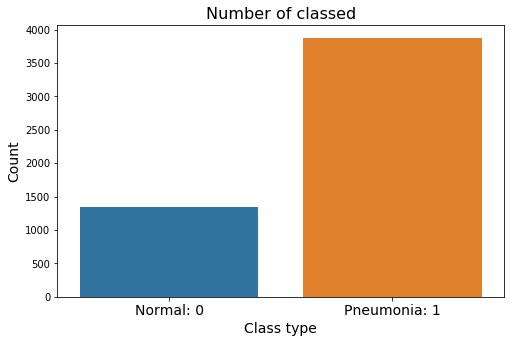

In [7]:
# counts for both classed
count_result = train_data['label'].value_counts()
print('Total of Train Data : ', len(train_data), '  (0 : Normal; 1 : Pneumonia)')

print(count_result)

# plot the results
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_data)   # ?
plt.title('Number of classed', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)),
          ['Normal: 0', 'Pneumonia: 1'],
          fontsize=14)
plt.show()

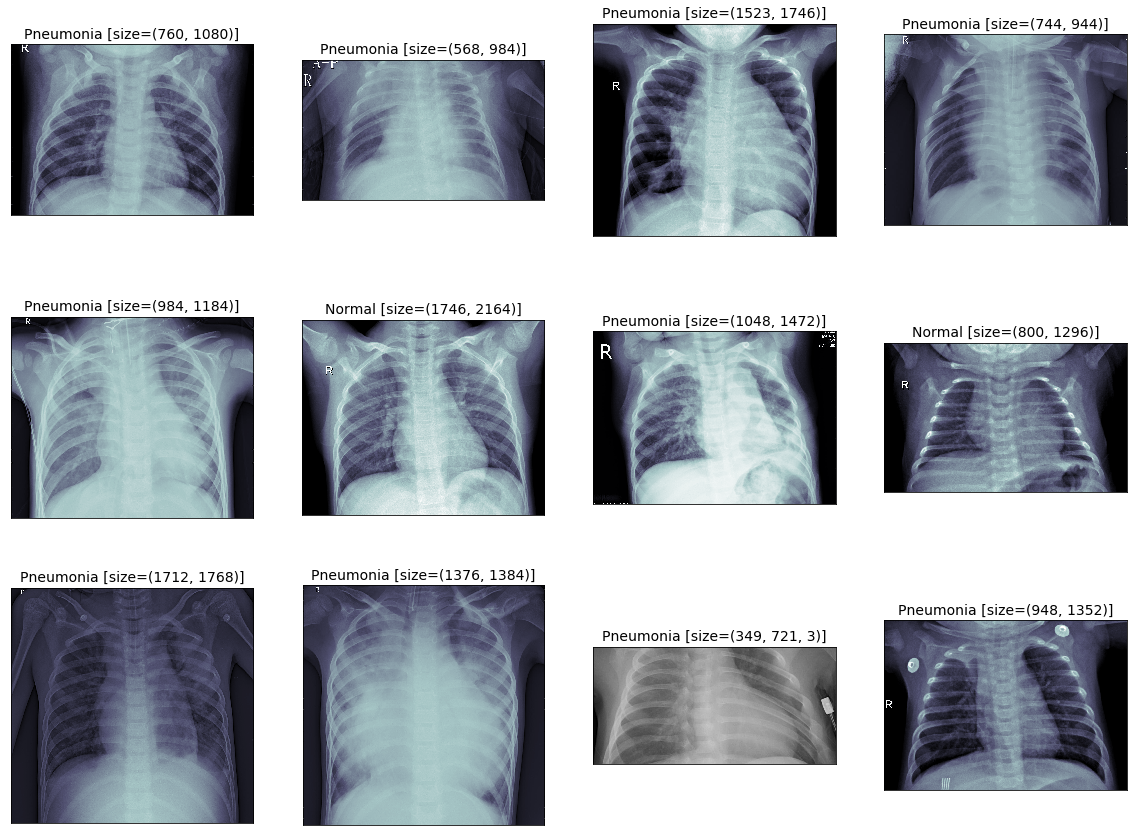

In [8]:
# 參考解釋: https://www.itread01.com/content/1544755526.html

fig, ax = plt.subplots(3, 4, figsize=(20, 15))
for i, axi in enumerate(ax.flat):
    img = imread(train_data.image[i])
    axi.imshow(img, cmap='bone')
    axi.set_title(('Normal' if train_data.label[i] == 0 else 'Pneumonia')
                 + ' [size=' + str(img.shape) + ']', fontsize=14)
    axi.set(xticks=[], yticks=[])  # 不要那些

In [9]:
train_data.to_numpy().shape

(5216, 2)

In [10]:
# Path(INPUT_PATH + files_dir + '/NORMAL').glob('*.jpeg')

In [11]:
# 批量輸入資料

def load_data(files_dir='/train'):
    normal = Path(INPUT_PATH + files_dir + '/NORMAL').glob('*.jpeg')
    pneumonia = Path(INPUT_PATH + files_dir + '/PNEUMONIA').glob('*.jpeg')
    
    normal_data = [(image, 0) for image in normal]
    pneumonia_data = [(image, 1) for image in pneumonia]

    image_data = normal_data + pneumonia_data

    # Get a pandas dataframe for the data paths 
    image_data = pd.DataFrame(image_data, columns=['image', 'label'])
    
    # Shuffle the data 
    image_data = image_data.sample(frac=1., random_state=18).reset_index(drop=True)
    
    # Importing both image & label datasets...
    x_images, y_labels = ([data_input(image_data.iloc[i][:]) for i in range(len(image_data))], 
                         [image_data.iloc[i][1] for i in range(len(image_data))])

    # Convert the list into numpy arrays
    x_images = np.array(x_images)
    y_labels = np.array(y_labels)
    
    print("Total number of images: ", x_images.shape)
    print("Total number of labels: ", y_labels.shape)
    
    return x_images, y_labels

In [12]:
# resize all the imgs to 224x224 with 3 channels
# normalize the pixel values

def data_input(dataset):
    # print(dataset.shape)
    for image_file in dataset:
        image = cv2.imread(str(image_file))
        image = cv2.resize(image, (224,224))
        if image.shape[2] == 1:
            # np.dstack(): Stack arrays in sequence depth-wise 
            #              (along third axis).
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html
            image = np.dstack([image, image, image])
        
        # ----------------------------------------------------------
        # cv2.cvtColor(): The function converts an input image 
        #                 from one color space to another. 
        # [Ref.1]: "cvtColor - OpenCV Documentation"
        #     - https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
        # [Ref.2]: "Python计算机视觉编程- 第十章 OpenCV" 
        #     - https://yongyuan.name/pcvwithpython/chapter10.html
        # ----------------------------------------------------------
        x_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Normalization
        x_image = x_image.astype(np.float32)/255.
        return x_image

In [13]:
# Import train dataset...
x_train, y_train = load_data(files_dir='/train')

print(x_train.shape)
print(y_train.shape)

Total number of images:  (5216, 224, 224, 3)
Total number of labels:  (5216,)
(5216, 224, 224, 3)
(5216,)


In [14]:
x_train[0].shape

(224, 224, 3)

In [15]:
x_train[0]

array([[[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.00784314, 0.00784314, 0.00784314],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.00784314, 0.00784314, 0.00784314],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [16]:
y_train

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [17]:
# Import validation dataset...
x_val, y_val = load_data(files_dir='/val')

print(x_val.shape)
print(y_val.shape)

Total number of images:  (16, 224, 224, 3)
Total number of labels:  (16,)
(16, 224, 224, 3)
(16,)


In [18]:
y_val

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1], dtype=int64)

In [19]:
# Import test dataset...
x_test, y_test = load_data(files_dir='/test')

print(x_test.shape)
print(y_test.shape)

Total number of images:  (624, 224, 224, 3)
Total number of labels:  (624,)
(624, 224, 224, 3)
(624,)


In [20]:
# Counts for both classes
count_result = pd.Series(y_test).value_counts()
print('Total of Test Data : ', len(y_test), '  (0 : Normal; 1 : Pneumonia)')
print('------------------')
print(count_result)
print('------------------')
print('1 :  ', count_result[1]/sum(count_result))
print('0 :  ', count_result[0]/sum(count_result))

Total of Test Data :  624   (0 : Normal; 1 : Pneumonia)
------------------
1    390
0    234
dtype: int64
------------------
1 :   0.625
0 :   0.375


## CNN model by tf.keras
- BN + Dropout
- Conv2D layer
- 1x1 Convolution


In [21]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', padding='same',
                input_shape=(224, 224, 3), name='Conv1_1'))
model.add(BatchNormalization(name='bn1_1'))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same',
                input_shape=(224, 224, 3), name='Conv1_2'))
model.add(BatchNormalization(name='bn1_2'))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same',
                input_shape=(224, 224, 3), name='Conv1_3'))
model.add(BatchNormalization(name='bn1_3'))
model.add(MaxPooling2D((2, 2), name='MaxPool1'))
model.add(Dropout(0.25))
model.add(Conv2D(48, (3, 3), activation='relu', padding='same',
                name='Conv2_1'))
model.add(BatchNormalization(name='bn2_1'))
model.add(Conv2D(48, (3, 3), activation='relu', padding='same',
                name='Conv2_2'))
model.add(BatchNormalization(name='bn2_2'))
model.add(Conv2D(48, (3, 3), activation='relu', padding='same',
                name='Conv2_3'))
model.add(BatchNormalization(name='bn2_3'))
model.add(MaxPooling2D((2, 2), name='MaxPool2'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                name='Conv3_1'))
model.add(BatchNormalization(name='bn3_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                name='Conv3_2'))
model.add(BatchNormalization(name='bn3_2'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                name='Conv3_3'))
model.add(BatchNormalization(name='bn3_3'))
model.add(MaxPooling2D((2, 2), name='MaxPool3'))
model.add(Dropout(0.25))
# ----------------------------------------------------------------------
    # Using "1x1 convolution layer" to lower the complexity of computing
    # [Ref]: Prof Andrew Ng, "Inception Module", 
    #        https://www.youtube.com/watch?v=KfV8CJh7hE0
    # ----------------------------------------------------------------------
    
model.add(Conv2D(64, (1,1), activation='relu', padding='same', name='Conv4_1_1x1'))
model.add(BatchNormalization(name='bn4_1_1x1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                name='Conv4_2'))
model.add(BatchNormalization(name='bn4_2'))
model.add(MaxPooling2D((2, 2), name='MaxPool4'))
model.add(Dropout(0.25))

# Using "1x1 convolution layer" 
model.add(Conv2D(128, (1,1), activation='relu', padding='same', name='Conv5_1_1x1'))
model.add(BatchNormalization(name='bn5_1_1x1'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='Conv5_2'))
model.add(BatchNormalization(name='bn5_2'))
model.add(MaxPooling2D((2,2), name='MaxPool5'))
model.add(Dropout(0.25))

# Using "1x1 convolution layer" 
model.add(Conv2D(256, (1,1), activation='relu', padding='same', name='Conv6_1x1'))
model.add(BatchNormalization(name='bn6_1x1'))
model.add(Conv2D(512, (3,3), activation='relu', name='Conv6_2'))
model.add(BatchNormalization(name='bn6_2'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu', name='fc'))
model.add(BatchNormalization(name='bn_fc'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid', name='Output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 224, 224, 32)      2432      
_________________________________________________________________
bn1_1 (BatchNormalization)   (None, 224, 224, 32)      128       
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 32)      25632     
_________________________________________________________________
bn1_2 (BatchNormalization)   (None, 224, 224, 32)      128       
_________________________________________________________________
Conv1_3 (Conv2D)             (None, 224, 224, 32)      25632     
_________________________________________________________________
bn1_3 (BatchNormalization)   (None, 224, 224, 32)      128       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 112, 112, 32)      0

In [22]:
import tensorflow as tf
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=85)

In [23]:
batch_size = 16
epochs_stage_1 = 10
epochs_stage_2 = 20
train_data_num = 4200

In [24]:
# Adam Optimizer with Learning-rate Decay 
basic_learning_rate = 0.001
opt = Adam(lr=basic_learning_rate, decay=basic_learning_rate/10.)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
# 發現跑不動~
## data_augmentation = False
print('Not using data augmentation.')
epochs = epochs_stage_1
history_no_data_aug = model.fit(x_train[:train_data_num], y_train[:train_data_num],
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_data=(x_train[train_data_num:], y_train[train_data_num:]),
                               # validation_data=(x_val, y_val),
                               shuffle=False)

Not using data augmentation.
Epoch 1/10


C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


 12/263 [>.............................] - ETA: 42:06 - loss: 0.8184 - accuracy: 0.6615

KeyboardInterrupt: 

# 傳統機器學習方法
- SVM
- 隨機森林
- KNN

In [26]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## SVM
- SVC
- LinearSVC

In [27]:
# 前面用CNN所以...

print(x_train.shape)
print(y_train.shape)

(5216, 224, 224, 3)
(5216,)


In [28]:
# 資料前處理，轉換shape

x_train_tra = x_train.reshape(5216, -1)
print(x_train_tra.shape)

(5216, 150528)


In [29]:
# 切分資料集
from sklearn.model_selection import train_test_split

x_train_tra, x_test_tra, y_train_tra, y_test_tra = train_test_split(x_train_tra, y_train, test_size=0.2, random_state=18)

In [30]:
print(x_train_tra.shape)
print(x_test_tra.shape)

(4172, 150528)
(1044, 150528)


In [31]:
# 12分鐘而已，感覺還行啊!!!
linear_svc = LinearSVC()

linear_svc.fit(x_train_tra, y_train_tra)

C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [32]:
# 看結果
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_pred = linear_svc.predict(x_test_tra)
acc = accuracy_score(y_pred, y_test_tra)
f1_score_svc = f1_score(y_test_tra, y_pred)
print(f'正確率(Linear_svc): {acc}')
print(f'F1-score: {f1_score_svc}')

正確率(Linear_svc): 0.9521072796934866
F1-score: 0.9682337992376112


In [33]:
x_test.shape

(624, 224, 224, 3)

## SVC with Test Data

In [34]:
# 利用真正的test data

x_test = x_test.reshape(624, -1)

y_pred = linear_svc.predict(x_test)
acc = accuracy_score(y_pred, y_test)
f1_score_svc = f1_score(y_test, y_pred)
print(f'Test data_正確率(Linear_svc): {acc}')
print(f'Test data_F1-score: {f1_score_svc}')

Test data_正確率(Linear_svc): 0.7403846153846154
Test data_F1-score: 0.8265524625267667


In [41]:
# 保存model

# from sklearn.externals import joblib #jbolib模块

#保存Model(注:save文件夹要预先建立，否则会报错)
# joblib.dump(linear_svc, './save/linear_svc.pkl')

#读取Model
# clf3 = joblib.load('save/linear_svc.pkl')

#测试读取后的Model
# print(clf3.predict(X[0:1]))

## Logistic Regression

In [36]:
log = LogisticRegression()
log.fit(x_train_tra, y_train_tra)

C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [37]:
y_pred = log.predict(x_test_tra)
acc = accuracy_score(y_pred, y_test_tra)
f1_score_log = f1_score(y_test_tra, y_pred)
print(f'正確率(LogisticRegression): {acc}')
print(f'F1-score: {f1_score_log}')

正確率(LogisticRegression): 0.9501915708812261
F1-score: 0.9670886075949368


In [38]:
# LogisticRegression with Test Data

y_pred = log.predict(x_test)
acc = accuracy_score(y_pred, y_test)
f1_score_log = f1_score(y_test, y_pred)

print(f'Test data_正確率(LogisticRegression): {acc}')
print(f'Test data_F1-score: {f1_score_log}')

Test data_正確率(LogisticRegression): 0.7371794871794872
Test data_F1-score: 0.8240343347639485


In [42]:
# 保存model

# from sklearn.externals import joblib

# joblib.dump(log, './save/logistic.pkl')

## 隨機森林

In [43]:
# 好快就fit好了

rf = RandomForestClassifier()

rf.fit(x_train_tra, y_train_tra)

RandomForestClassifier()

In [44]:
# 測試資料

y_pred = rf.predict(x_test)

acc = accuracy_score(y_test, y_pred)
f1_score_rf = f1_score(y_test, y_pred)

print(f'Test data(RandomForest) acc : {acc}')
print(f'Test data(RandomForest) f1-score: {f1_score_rf}')

Test data(RandomForest) acc : 0.7451923076923077
Test data(RandomForest) f1-score: 0.828848223896663
